In [1]:
#import all the libraries needed!
import pandas as pd
import numpy as np
import folium 
!pip install geopy
from geopy.geocoders import Nominatim
import requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print('IMPORT COMPLETED!')


     |████████████████████████████████| 122kB 6.0MB/s eta 0:00:01
IMPORT COMPLETED!


# Step 1. Data Collection & Cleaning

### Getting Rent Rate Data for Los Angeles County Neighborhoods

In [2]:
url = 'https://usc.data.socrata.com/api/views/4a97-v5tx/rows.csv?accessType=DOWNLOAD&bom=true&format=true'

Rent_df = pd.read_csv(url)
print(Rent_df.shape)
Rent_df.head()

(16390, 12)


,Policy Area,Dataset,Variable,Year,Amount,Tract,Tract Number,Neighborhood,GEOID,Location,Row ID,Date
0,Housing & Real Estate,Rent Price,Median Rent Price,2015,"1,115","Census Tract 9200.23, Los Angeles County, Cali...",920023,Santa Clarita,1400000US06037920023,"(34.4214975, -118.4905135)",Median_Rent_Price_2015_1400000US06037920023,01/01/2015
1,Housing & Real Estate,Rent Price,Median Rent Price,2015,"1,038","Census Tract 5344.04, Los Angeles County, Cali...",534404,Cudahy,1400000US06037534404,"(33.966232, -118.190553)",Median_Rent_Price_2015_1400000US06037534404,01/01/2015
2,Housing & Real Estate,Rent Price,Median Rent Price,2015,"1,031","Census Tract 5336.01, Los Angeles County, Cali...",533601,Bell,1400000US06037533601,"(33.9803325, -118.194495)",Median_Rent_Price_2015_1400000US06037533601,01/01/2015
3,Housing & Real Estate,Rent Price,Median Rent Price,2015,"1,362","Census Tract 4053.02, Los Angeles County, Cali...",405302,West Covina,1400000US06037405302,"(34.0767645, -117.946434)",Median_Rent_Price_2015_1400000US06037405302,01/01/2015
4,Housing & Real Estate,Rent Price,Median Rent Price,2015,919,"Census Tract 2042, Los Angeles County, California",204200,Boyle Heights,1400000US06037204200,"(34.043615, -118.205084)",Median_Rent_Price_2015_1400000US06037204200,01/01/2015


### Data Pre-Processing

First, we only keep the rent rate for year 2016. 

In [3]:
Rent_df = Rent_df[Rent_df['Year'] == 2016]
Rent_df.shape

(2344, 12)

Then, we drop a few columns that we don't need

In [4]:
Rent_df.drop(['Policy Area', 'Dataset', 'Variable', 'Tract', 'Tract Number', 'GEOID', 'Row ID', 'Date'], inplace=True, axis=1)
Rent_df.head()

,Year,Amount,Neighborhood,Location
6,2016,791,Pacoima,"(34.2400435, -118.404715)"
9,2016,NaN,North Hills,"(34.2281815, -118.4920695)"
22,2016,"1,000",Pacoima,"(34.27316, -118.4202235)"
30,2016,"1,423",Northridge,"(34.244559, -118.537408)"
40,2016,"2,181",Northridge,"(34.253636, -118.5358265)"


Now, we drop any rows with NaN values and then reset the index. 

In [5]:
Rent_df.dropna(inplace=True)
Rent_df.reset_index(inplace=True, drop=True)
Rent_df.shape

(2296, 4)

Removing the comma in **Amount** values and converting the type to integers. 

In [6]:
Rent_df['Amount'] = Rent_df['Amount'].str.replace(',', '')
Rent_df['Amount'] = Rent_df['Amount'].apply(pd.to_numeric)
Rent_df.dtypes

Year             int64
Amount           int64
Neighborhood    object
Location        object
dtype: object

Let's take a look at the statistics of the data frame

In [7]:
Rent_df.describe()

,Year,Amount
count,2296.0,2296.000000
mean,2016.0,1419.796603
std,0.0,485.071219
min,2016.0,299.000000
25%,2016.0,1096.750000
50%,2016.0,1274.000000
75%,2016.0,1628.000000
max,2016.0,3500.000000


We see that the rent rate in L.A. County is between **299** to **3500** dollars per month. 

The rent data we collected from USC has multiple rates for each neighborhood. In two steps we will fix this.
In the 1st step, we make a new data frame that is grouped by **Neighborhood** and has the max rent rate for each one. 


In [8]:
new_Rent_df = Rent_df.groupby('Neighborhood').max()
new_Rent_df.reset_index(inplace=True)
new_Rent_df.head()

,Neighborhood,Year,Amount,Location
0,Acton,2016,1500,"(34.528856, -118.187391)"
1,Adams-Normandie,2016,1093,"(34.034856, -118.3046185)"
2,Agoura Hills,2016,3321,"(34.1610355, -118.7705735)"
3,Alhambra,2016,1525,"(34.104914, -118.1317765)"
4,Alondra Park,2016,1484,"(33.885925, -118.335435)"


In the 2nd step, we create another data frame which has the average rent rate for each **Neighborhood**.

In [9]:
avg_Rent_df = Rent_df.groupby('Neighborhood').mean()
avg_Rent_df.reset_index(inplace=True)
print(avg_Rent_df.shape)
avg_Rent_df.head()

(257, 3)


,Neighborhood,Year,Amount
0,Acton,2016.0,1500.00
1,Adams-Normandie,2016.0,984.20
2,Agoura Hills,2016.0,2488.00
3,Alhambra,2016.0,1245.75
4,Alondra Park,2016.0,1484.00


Now we assign the average rent rate for each neighborhood to the new_Rent_df. 

In [10]:
new_Rent_df['Amount'] = avg_Rent_df['Amount']
new_Rent_df.head()

,Neighborhood,Year,Amount,Location
0,Acton,2016,1500.00,"(34.528856, -118.187391)"
1,Adams-Normandie,2016,984.20,"(34.034856, -118.3046185)"
2,Agoura Hills,2016,2488.00,"(34.1610355, -118.7705735)"
3,Alhambra,2016,1245.75,"(34.104914, -118.1317765)"
4,Alondra Park,2016,1484.00,"(33.885925, -118.335435)"


Let's change the column name to **MGR** (Median Rent Price).

In [11]:
new_Rent_df.rename(columns={'Amount': 'MGR'}, inplace=True)
new_Rent_df.head()

,Neighborhood,Year,MGR,Location
0,Acton,2016,1500.00,"(34.528856, -118.187391)"
1,Adams-Normandie,2016,984.20,"(34.034856, -118.3046185)"
2,Agoura Hills,2016,2488.00,"(34.1610355, -118.7705735)"
3,Alhambra,2016,1245.75,"(34.104914, -118.1317765)"
4,Alondra Park,2016,1484.00,"(33.885925, -118.335435)"


Now, we separate the latitude and longitude values from **Location** and assign them to their own columns and then drop the **Location** column. 

In [12]:
new_Rent_df[['Latitude', 'Longitude']] = new_Rent_df['Location'].str[1:-1].str.split(',', expand=True).astype(float)
new_Rent_df.drop('Location', axis=1, inplace=True)
new_Rent_df.head()

,Neighborhood,Year,MGR,Latitude,Longitude
0,Acton,2016,1500.00,34.528856,-118.187391
1,Adams-Normandie,2016,984.20,34.034856,-118.304619
2,Agoura Hills,2016,2488.00,34.161035,-118.770573
3,Alhambra,2016,1245.75,34.104914,-118.131777
4,Alondra Park,2016,1484.00,33.885925,-118.335435


# Step 2. Data Visualization 

Let's check out the histogram of MGR in year 2016

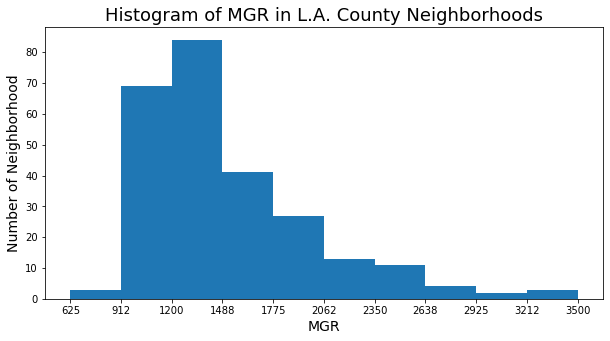

In [23]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

count, bin_edges = np.histogram(new_Rent_df['MGR'])

new_Rent_df['MGR'].plot(kind='hist', figsize=(10, 5), xticks=bin_edges)

plt.title('Histogram of MGR in L.A. County Neighborhoods', fontsize=18) # add a title to the histogram
plt.ylabel('Number of Neighborhood', fontsize=14) # add y-label
plt.xlabel('MGR', fontsize=14) # add x-label

plt.show()

Let's get the coordinates of L.A. County. 

In [86]:
address = 'Los Angeles County, CA'

geolocator = Nominatim(user_agent="LA_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles County are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles County are 34.3155072, -118.2096814.


Now, we superimpose the neighborhoods on the map.

In [87]:
map_LA_Nhood = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, neighborhood in zip(new_Rent_df['Latitude'], new_Rent_df['Longitude'], new_Rent_df['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA_Nhood)
    
    
map_LA_Nhood

Let's take a look at 10 most expensive neighborhoods in L.A. County

In [85]:
Top10_df = new_Rent_df.sort_values('MGR', ascending=False).head(10)
Top10_df.set_index('Neighborhood', inplace=True)
Top10_df.head(10)

,Year,MGR,Latitude,Longitude
Neighborhood,,,,
San Marino,2016,3500.000000,34.125398,-118.098356
Rolling Hills,2016,3500.000000,33.760874,-118.347924
Beverlywood,2016,3463.000000,34.041931,-118.393355
Malibu,2016,3202.000000,34.022940,-118.799901
Palos Verdes Estates,2016,2930.000000,33.797687,-118.379741
Westlake Village,2016,2811.500000,34.158577,-118.801884
Pacific Palisades,2016,2686.833333,34.073806,-118.556781
Porter Ranch,2016,2678.428571,34.293953,-118.547051
Rancho Palos Verdes,2016,2639.500000,33.785891,-118.378968


Now let's visulaize these neighborhood on a bar chart

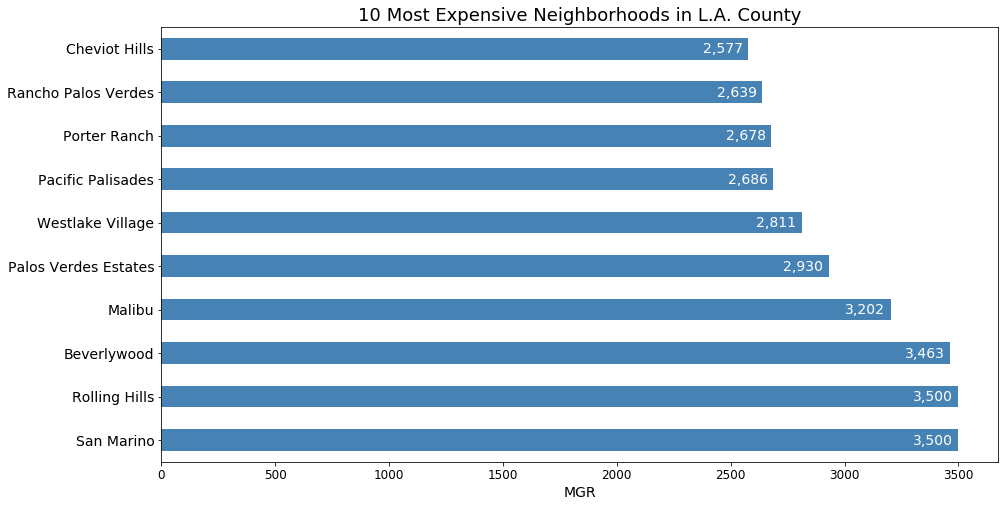

In [88]:
Top10_df['MGR'].plot(kind='barh', figsize=(15,8), color='steelblue')

plt.xlabel('MGR', fontsize= 14)
plt.ylabel('')
plt.title('10 Most Expensive Neighborhoods in L.A. County', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)

for index, value in enumerate(Top10_df['MGR']): 
    label = format(int(value), ',')
    
    plt.annotate(label, xy=(value-200 , index - 0.10), color='white', fontsize=14)




Now we show these 10 expensive neighborhoods on the map. 

In [185]:
map_top10 = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, neighborhood in zip(Top10_df['Latitude'], Top10_df['Longitude'], Top10_df.index):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_top10)
    
    
map_top10

# Step 3. Clutering Neighborhoods based on the Rent Rate and their distance from a work place.

 First, let's select a neighborhood randomly as the location for the new job. 

In [92]:
work_Nhood = new_Rent_df.sample()
print('The new job is located in {}'.format(work_Nhood.iloc[0,0]))

The new job is located in Long Beach


In [93]:
work_Nhood.head()

,Neighborhood,Year,MGR,Latitude,Longitude
127,Long Beach,2016,1276.53271,33.879894,-118.178127


Let's create a function that calculates the distance of two points on earth based on their coordinates using the Haversine formula. 

In [94]:
from math import radians, cos, sin, asin, sqrt 
def distance(lat1, lat2, lon1, lon2): 
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = np.radians(lon1) 
    lon2 = np.radians(lon2) 
    lat1 = np.radians(lat1) 
    lat2 = np.radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
  
    c = 2 * np.arcsin(np.sqrt(a))  
     
    # Radius of earth in miles. 
    r = 3956
       
    # calculate the result in miles 
    return(c * r) 

 Calculating the miles distance between workplace and neighborhoods and adding it to the data frame.

In [95]:
new_Rent_df['Distance'] = distance(new_Rent_df['Latitude'], work_Nhood.iloc[0,3], new_Rent_df['Longitude'], work_Nhood.iloc[0,4])
new_Rent_df.head()

,Neighborhood,Year,MGR,Latitude,Longitude,Distance
0,Acton,2016,1500.00,34.528856,-118.187391,44.810885
1,Adams-Normandie,2016,984.20,34.034856,-118.304619,12.921127
2,Agoura Hills,2016,2488.00,34.161035,-118.770573,39.067745
3,Alhambra,2016,1245.75,34.104914,-118.131777,15.761534
4,Alondra Park,2016,1484.00,33.885925,-118.335435,9.026514


### Preparing the data for clustering

Let's only keep **Neighborhood**, **Avg_Rent**, and **Distance** columns and drop the rest to prepare the data frame for clustering. 

In [96]:
Cluster_Rent_df = new_Rent_df.drop(['Year', 'Latitude', 'Longitude'], axis=1)
print(Cluster_Rent_df.shape)
Cluster_Rent_df.head()

(257, 3)


,Neighborhood,MGR,Distance
0,Acton,1500.00,44.810885
1,Adams-Normandie,984.20,12.921127
2,Agoura Hills,2488.00,39.067745
3,Alhambra,1245.75,15.761534
4,Alondra Park,1484.00,9.026514


### Normalizing the data

In [97]:
from sklearn.preprocessing import StandardScaler

X = Cluster_Rent_df.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.03232063,  2.06383789],
       [-1.06842285, -0.56981983],
       [ 1.95230325,  1.58953311],
       [-0.54303988, -0.33524105],
       [-0.06446029, -0.89146165],
       [-0.02353244,  0.23298325],
       [-0.50838931,  1.0383435 ],
       [-0.08600847,  0.13111907],
       [ 0.22513142,  0.84504942],
       [-0.85589936, -0.47137659],
       [-0.21712366, -1.18605508],
       [-1.06480714, -0.99867251],
       [-0.17427078, -0.10426764],
       [-0.18096655,  1.50527279],
       [-0.39489614, -0.36031682],
       [-0.37661671,  0.33830702],
       [-0.91386553, -0.42441168],
       [-0.51152795,  0.03544817],
       [ 1.03029681,  0.23003811],
       [-0.94686607, -1.05899366],
       [-0.77644299, -1.09636007],
       [-0.61128086, -1.32870599],
       [ 1.75143039,  0.17061731],
       [ 0.58009051, -0.15014349],
       [ 1.62574137,  0.03158838],
       [ 3.91081366, -0.26219325],
       [-1.06689622, -0.6040446 ],
       [ 1.57466227,  0.2153848 ],
       [ 1.56662736,

### Modeling: We will cluster all the neighborhoods into 5 distinct group. 

In [103]:
from sklearn.cluster import KMeans
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[1 0 2 0 0 4 4 4 4 0 0 0 4 4 0 4 0 4 3 0 0 0 2 3 2 2 0 2 2 0 4 2 4 0 3 2 1
 0 2 3 4 4 4 0 2 0 4 4 0 0 4 0 3 0 0 3 3 0 0 4 4 0 0 0 0 4 4 0 0 3 0 1 0 0
 3 0 3 0 0 0 0 4 3 0 2 0 3 3 0 0 0 0 0 0 3 2 0 0 0 3 3 0 0 3 0 4 0 0 2 3 3
 0 0 4 3 4 1 4 0 1 0 0 0 0 1 0 0 0 4 4 0 2 0 3 3 2 4 0 0 3 4 4 0 0 0 0 4 4
 3 1 4 1 1 0 2 4 1 3 2 4 0 4 0 3 0 3 3 4 2 1 3 0 2 3 3 4 1 2 3 0 3 3 4 0 2
 4 0 1 0 3 3 3 4 3 0 0 0 0 0 3 0 4 0 1 2 3 4 4 4 3 0 4 2 3 4 2 4 2 1 0 4 4
 4 4 3 0 0 0 0 0 4 0 4 3 0 0 0 0 0 4 2 4 3 0 0 3 0 2 0 3 0 0 0 0 0 4 2]


In [104]:
new_Rent_df.head()

,Neighborhood,Year,MGR,Latitude,Longitude,Distance,Cluster
0,Acton,2016,1500.00,34.528856,-118.187391,44.810885,3
1,Adams-Normandie,2016,984.20,34.034856,-118.304619,12.921127,2
2,Agoura Hills,2016,2488.00,34.161035,-118.770573,39.067745,4
3,Alhambra,2016,1245.75,34.104914,-118.131777,15.761534,2
4,Alondra Park,2016,1484.00,33.885925,-118.335435,9.026514,2


 Let's assign each row to their correspondent cluster.

In [105]:
new_Rent_df['Cluster'] = labels
new_Rent_df.head()

,Neighborhood,Year,MGR,Latitude,Longitude,Distance,Cluster
0,Acton,2016,1500.00,34.528856,-118.187391,44.810885,1
1,Adams-Normandie,2016,984.20,34.034856,-118.304619,12.921127,0
2,Agoura Hills,2016,2488.00,34.161035,-118.770573,39.067745,2
3,Alhambra,2016,1245.75,34.104914,-118.131777,15.761534,0
4,Alondra Park,2016,1484.00,33.885925,-118.335435,9.026514,0


Now we plot the clusters together!

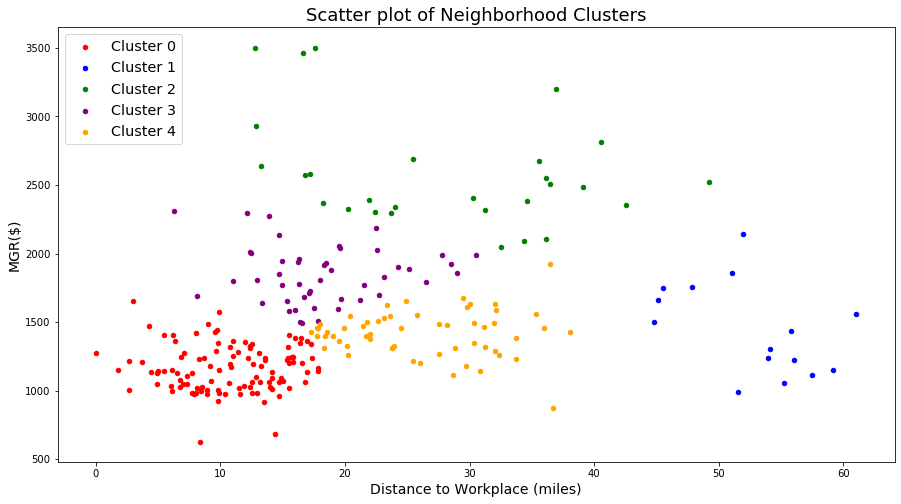

In [146]:
cluster_0 = new_Rent_df[new_Rent_df['Cluster']==0].plot(kind='scatter', x='Distance', y='MGR', color='red', figsize=(15,8))
cluster_1 = new_Rent_df[new_Rent_df['Cluster']==1].plot(kind='scatter', x='Distance', y='MGR', color='blue', figsize=(15,8), ax=cluster_0)
cluster_2 = new_Rent_df[new_Rent_df['Cluster']==2].plot(kind='scatter', x='Distance', y='MGR', color='green', figsize=(15,8), ax=cluster_0)
cluster_3 = new_Rent_df[new_Rent_df['Cluster']==3].plot(kind='scatter', x='Distance', y='MGR', color='purple', figsize=(15,8), ax=cluster_0)
cluster_4 = new_Rent_df[new_Rent_df['Cluster']==4].plot(kind='scatter', x='Distance', y='MGR', color='orange', figsize=(15,8), ax=cluster_0)

cluster_0.set_xlabel('Distance to Workplace (miles)', fontsize=14)
cluster_0.set_ylabel('MGR($)', fontsize=14)

cluster_0.set_title('Scatter plot of Neighborhood Clusters', fontsize=18)
cluster_0.legend(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], loc='upper left', fontsize='x-large')

### Now let's visualize the clusters on the map

In [147]:
map_LA_Nhood = folium.Map(location=[latitude, longitude], zoom_start=9)
colors = ['red', 'blue', 'green', 'purple', 'orange']

# add markers to map
for lat, lng, neighborhood, cluster in zip(new_Rent_df['Latitude'], new_Rent_df['Longitude'], new_Rent_df['Neighborhood'], new_Rent_df['Cluster']):
    label = '{}, Cluster {}'.format(neighborhood, cluster)
    label = folium.Popup(label, parse_html=True)
    if neighborhood == work_Nhood.iloc[0,0]:   # work neighborhood will be shown in black circle. 
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= 'black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA_Nhood)
    else:                                     #each cluster will be shown in a different color. 
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color= colors[cluster],
            fill=True,
            fill_color=colors[cluster],
            fill_opacity=0.7,
            parse_html=False).add_to(map_LA_Nhood)
    
    
map_LA_Nhood

#### Let's take a look at each cluster

In [151]:
Cluster_0 = new_Rent_df[new_Rent_df['Cluster']==0]
print(Cluster_0.shape)
Cluster_0.head()

(110, 7)


,Neighborhood,Year,MGR,Latitude,Longitude,Distance,Cluster
1,Adams-Normandie,2016,984.20,34.034856,-118.304619,12.921127,0
3,Alhambra,2016,1245.75,34.104914,-118.131777,15.761534,0
4,Alondra Park,2016,1484.00,33.885925,-118.335435,9.026514,0
9,Arlington Heights,2016,1090.00,34.050804,-118.313311,14.113131,0
10,Artesia,2016,1408.00,33.876682,-118.082966,5.459416,0


In [152]:
Cluster_1 = new_Rent_df[new_Rent_df['Cluster']==1]
print(Cluster_1.shape)
Cluster_1.head()

(15, 7)


,Neighborhood,Year,MGR,Latitude,Longitude,Distance,Cluster
0,Acton,2016,1500.000000,34.528856,-118.187391,44.810885,1
36,Castaic Canyons,2016,1861.555556,34.602204,-118.370304,51.064112,1
71,Elizabeth Lake,2016,1224.000000,34.673752,-118.383647,56.052321,1
116,Lake Los Angeles,2016,1052.000000,34.631220,-117.845138,55.246507,1
119,Lancaster,2016,1111.111111,34.711419,-118.121494,57.503704,1


In [153]:
Cluster_2 = new_Rent_df[new_Rent_df['Cluster']==2]
print(Cluster_2.shape)
Cluster_2.head()

(28, 7)


,Neighborhood,Year,MGR,Latitude,Longitude,Distance,Cluster
2,Agoura Hills,2016,2488.000000,34.161035,-118.770573,39.067745,2
22,Beverly Crest,2016,2388.000000,34.108261,-118.443290,21.886742,2
24,Beverly Hills,2016,2325.428571,34.110602,-118.395214,20.203304,2
25,Beverlywood,2016,3463.000000,34.041931,-118.393355,16.646037,2
27,Bradbury,2016,2300.000000,34.154399,-117.968573,22.428811,2


In [154]:
Cluster_3 = new_Rent_df[new_Rent_df['Cluster']==3]
print(Cluster_3.shape)
Cluster_3.head()

(47, 7)


,Neighborhood,Year,MGR,Latitude,Longitude,Distance,Cluster
18,Bel-Air,2016,2029.000000,34.101563,-118.468744,22.606241,3
23,Beverly Grove,2016,1804.875000,34.085194,-118.371972,18.002796,3
34,Carthay,2016,1780.000000,34.059083,-118.363807,16.313119,3
39,Cerritos,2016,2306.545455,33.883975,-118.068399,6.295949,3
52,Culver City,2016,1580.285714,34.026229,-118.383963,15.526170,3


In [155]:
Cluster_4 = new_Rent_df[new_Rent_df['Cluster']==4]
print(Cluster_4.shape)
Cluster_4.head()

(57, 7)


,Neighborhood,Year,MGR,Latitude,Longitude,Distance,Cluster
5,Altadena,2016,1504.375000,34.207322,-118.156289,22.641903,4
6,Angeles Crest,2016,1263.000000,34.294753,-117.913563,32.393642,4
7,Arcadia,2016,1473.272727,34.162478,-118.024156,21.408476,4
8,Arleta,2016,1628.166667,34.255955,-118.442705,30.053132,4
12,Atwater Village,2016,1429.333333,34.137637,-118.270105,18.558286,4


### Comparing the clusters based on average rent rate and linear Distance

In [156]:
Clusters = new_Rent_df.groupby('Cluster').mean()
Clusters.reset_index(inplace=True)
Clusters.head()

,Cluster,Year,MGR,Latitude,Longitude,Distance
0,0,2016,1165.165774,33.991797,-118.220160,10.760151
1,1,2016,1448.144614,34.617854,-118.256763,52.706345
2,2,2016,2584.336369,34.124481,-118.495546,27.802967
3,3,2016,1843.725890,34.042906,-118.273470,18.172678
4,4,2016,1416.284455,34.155622,-118.229795,26.090153


#### Let's select the cluster with the lowest rent rate that has either the lowest or second lowest linear distance and mark it as the cluster of choice. 

In [157]:
cluster_of_choice = Clusters.sort_values('Distance').head(2).sort_values('MGR').head(1).iloc[0,0]
print('Cluster of choice to relocate is cluster {}.'.format(cluster_of_choice))

Cluster of choice to relocate is cluster 0.


Make a data frame that only has neighborhoods in the cluster of choice.

In [158]:
choice_df = new_Rent_df[new_Rent_df['Cluster']==cluster_of_choice]
choice_df.reset_index(inplace=True, drop= True)
choice_df.head()

,Neighborhood,Year,MGR,Latitude,Longitude,Distance,Cluster
0,Adams-Normandie,2016,984.20,34.034856,-118.304619,12.921127,0
1,Alhambra,2016,1245.75,34.104914,-118.131777,15.761534,0
2,Alondra Park,2016,1484.00,33.885925,-118.335435,9.026514,0
3,Arlington Heights,2016,1090.00,34.050804,-118.313311,14.113131,0
4,Artesia,2016,1408.00,33.876682,-118.082966,5.459416,0


# Step 4. Filtering the neighborhoods in the cluster of choice to choose the final neighborhood to move in. 

#### First, take a look at neighborhoods of choice on the map

In [159]:
map_choice_Nhood = folium.Map(location=[latitude, longitude], zoom_start=9)
colors = ['red', 'blue', 'green', 'purple', 'yellow']

# add markers to map
for lat, lng, neighborhood, cluster in zip(choice_df['Latitude'], choice_df['Longitude'], choice_df['Neighborhood'], choice_df['Cluster']):
    label = '{}, {}'.format(neighborhood, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color= 'green',
    fill=True,
    fill_color='black',
    fill_opacity=0.7,
    parse_html=False).add_to(map_choice_Nhood)
    
    
    
map_choice_Nhood

### Now that we have the cluster of choice, let's get the venues information in that specific cluster

##### Define Foursquare Credentials and Version

In [160]:
CLIENT_ID = 'J0GPZTC4NA5Q12YWL101RVQRFYYTJWP10W1BZEH020ZUENMS' # your Foursquare ID
CLIENT_SECRET = 'Q1ZMN0FASRPSBW4BGPXDTUJRWHMVRLHN2O1DIBUBRGY4JYCW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: J0GPZTC4NA5Q12YWL101RVQRFYYTJWP10W1BZEH020ZUENMS
CLIENT_SECRET:Q1ZMN0FASRPSBW4BGPXDTUJRWHMVRLHN2O1DIBUBRGY4JYCW


#### Let's explore the first neighborhood in the data frame

get the neighborhood's info

In [161]:
neighborhood_latitude = choice_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = choice_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = choice_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Adams-Normandie are 34.034856, -118.3046185.


#### Now, let's get the top 100 venues that are in this neghborhood within a radius of 500 meters.

In [162]:
LIMIT = 100 
radius = 500
Latitude = 34.2559555
Longitude = -118.442705

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=J0GPZTC4NA5Q12YWL101RVQRFYYTJWP10W1BZEH020ZUENMS&client_secret=Q1ZMN0FASRPSBW4BGPXDTUJRWHMVRLHN2O1DIBUBRGY4JYCW&v=20180605&ll=34.034856,-118.3046185&radius=500&limit=100'

In [163]:
# Send the Get and examine the result
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ef64bd36c350d492543a35b'},
 'response': {'headerLocation': 'South LA',
  'headerFullLocation': 'South LA, Los Angeles',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 34.0393560045, 'lng': -118.29919842340571},
   'sw': {'lat': 34.030355995499995, 'lng': -118.3100385765943}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ea0f51bd22d13862bfd54a8',
       'name': 'Haunted Play: Delusion',
       'location': {'address': '2218 S Harvard Blvd',
        'lat': 34.035859825818946,
        'lng': -118.30624828076333,
        'labeledLatLngs': [{'label': 'display',
          'lat': 34.035859825818946,
          'lng': -118.30624828076333},
         {'label': 'entrance', 'lat': 34.035

In [164]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [165]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Haunted Play: Delusion,Indie Theater,34.035860,-118.306248
1,Shell,Gas Station,34.033095,-118.300025
2,Loren Miller Recreational Park,Playground,34.031335,-118.303717
3,Tacos La Estrella,Taco Place,34.032230,-118.300757


#### Let's create a function to repeat the same process to all the neighborhoods in the cluster

In [166]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *cluster_venues*.

In [167]:
cluster_venues = getNearbyVenues(names=choice_df['Neighborhood'],
                                   latitudes=choice_df['Latitude'],
                                   longitudes=choice_df['Longitude']
                                  )

Adams-Normandie
Alhambra
Alondra Park
Arlington Heights
Artesia
Athens
Avocado Heights
Baldwin Hills/Crenshaw
Bell
Bell Gardens
Bellflower
Boyle Heights
Broadway-Manchester
Carson
Central-Alameda
Chesterfield Square
Chinatown
Commerce
Compton
Cudahy
Cypress Park
Del Aire
Downey
Downtown
East Compton
East Hollywood
East La Mirada
East Los Angeles
Echo Park
El Monte
El Sereno
Elysian Park
Elysian Valley
Exposition Park
Florence
Florence-Firestone
Gardena
Glassell Park
Gramercy Park
Green Meadows
Harbor City
Harbor Gateway
Harvard Heights
Harvard Park
Hawaiian Gardens
Hawthorne
Highland Park
Historic South-Central
Hollywood
Huntington Park
Hyde Park
Inglewood
Jefferson Park
Koreatown
La Mirada
La Puente
Lakewood
Larchmont
Lawndale
Leimert Park
Lennox
Lincoln Heights
Lomita
Long Beach
Lynwood
Manchester Square
Maywood
Mid-City
Montebello
Montecito Heights
Monterey Park
Mount Washington
Norwalk
Paramount
Pico Rivera
Pico-Union
Rancho Dominguez
Rosemead
San Gabriel
San Pedro
Santa Fe Springs

#### Let's check the result

In [168]:
print(cluster_venues.shape)
cluster_venues.head()

(1193, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adams-Normandie,34.034856,-118.304619,Haunted Play: Delusion,34.035860,-118.306248,Indie Theater
1,Adams-Normandie,34.034856,-118.304619,Shell,34.033095,-118.300025,Gas Station
2,Adams-Normandie,34.034856,-118.304619,Loren Miller Recreational Park,34.031335,-118.303717,Playground
3,Adams-Normandie,34.034856,-118.304619,Tacos La Estrella,34.032230,-118.300757,Taco Place
4,Alhambra,34.104914,-118.131777,In-N-Out Burger,34.106211,-118.134465,Fast Food Restaurant


Let's check how many venues were returned for each neighborhood

In [169]:
cluster_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adams-Normandie,4,4,4,4,4,4
Alhambra,14,14,14,14,14,14
Alondra Park,4,4,4,4,4,4
Arlington Heights,38,38,38,38,38,38
Artesia,30,30,30,30,30,30
...,...,...,...,...,...,...
Whittier,1,1,1,1,1,1
Whittier Narrows,1,1,1,1,1,1
Willowbrook,5,5,5,5,5,5


## Analyze Each Neighborhood

In [170]:
# one hot encoding
cluster_onehot = pd.get_dummies(cluster_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cluster_onehot['Neighborhood'] = cluster_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cluster_onehot.columns[-1]] + list(cluster_onehot.columns[:-1])
cluster_onehot = cluster_onehot[fixed_columns]

cluster_onehot.head()

,Neighborhood,ATM,Adult Boutique,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alhambra,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [171]:
cluster_grouped = cluster_onehot.groupby('Neighborhood').mean().reset_index()
cluster_grouped

,Neighborhood,ATM,Adult Boutique,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Adams-Normandie,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,Alhambra,0.071429,0.0,0.071429,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0
2,Alondra Park,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington Heights,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.026316,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Artesia,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Whittier,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
104,Whittier Narrows,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
105,Willowbrook,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
106,Wilmington,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


First, let's write a function to sort the venues in descending order.

In [172]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [173]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cluster_grouped['Neighborhood']

for ind in np.arange(cluster_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams-Normandie,Playground,Indie Theater,Taco Place,Gas Station,Drugstore,Fish & Chips Shop,Film Studio,Filipino Restaurant,Fast Food Restaurant,Farmers Market
1,Alhambra,ATM,Auto Garage,IT Services,Flower Shop,Fast Food Restaurant,Optical Shop,Convenience Store,Bus Station,Burger Joint,Supermarket
2,Alondra Park,Deli / Bodega,Park,Football Stadium,Baseball Field,Yoga Studio,Dumpling Restaurant,Fish Market,Fish & Chips Shop,Film Studio,Filipino Restaurant
3,Arlington Heights,Korean Restaurant,Massage Studio,Liquor Store,Mexican Restaurant,Health & Beauty Service,Theater,Café,Sandwich Place,Bar,Bakery
4,Artesia,Korean Restaurant,Fast Food Restaurant,Sandwich Place,Breakfast Spot,Nightclub,Thai Restaurant,Tea Room,Filipino Restaurant,Mexican Restaurant,Karaoke Bar


#### Let's find out how many unique categories can be curated from all the returned venues

In [174]:
venues_list = (cluster_venues['Venue Category'].unique()).tolist()
print('There are {} uniques categories.'.format(len(cluster_venues['Venue Category'].unique())))

There are 219 uniques categories.


Let's print the list of venues and ask user to select 3 most important venues of theirs:

In [175]:
print('Here is a list of all the venues in this cluster of choice:\n\n', venues_list)

Here is a list of all the venues in this cluster of choice:

 ['Indie Theater', 'Gas Station', 'Playground', 'Taco Place', 'Fast Food Restaurant', 'Sushi Restaurant', 'Convenience Store', 'Burger Joint', 'American Restaurant', 'Supermarket', 'ATM', 'Pizza Place', 'Video Store', 'Optical Shop', 'Bus Station', 'Flower Shop', 'IT Services', 'Auto Garage', 'Park', 'Football Stadium', 'Deli / Bodega', 'Baseball Field', 'Korean Restaurant', 'Historic Site', 'Mexican Restaurant', 'BBQ Joint', 'Cosmetics Shop', 'Grocery Store', 'Shopping Mall', 'Discount Store', 'Café', 'Sandwich Place', 'Theater', 'Liquor Store', 'Massage Studio', 'Asian Restaurant', 'Creperie', 'Bar', 'Bakery', 'Health & Beauty Service', 'Gun Range', 'Coffee Shop', 'Filipino Restaurant', 'Gastropub', 'Hotel', 'Chinese Restaurant', 'Breakfast Spot', 'Thai Restaurant', 'Bank', 'Pharmacy', 'Nightclub', 'Karaoke Bar', 'Tea Room', 'Hawaiian Restaurant', 'Donut Shop', 'Boat or Ferry', 'Fried Chicken Joint', 'Food Truck', 'Kitchen 

In [180]:
venue_1 = input('please enter the most important venue from the list above:\n\n ')
venue_2 = input('please enter the 2nd most important venue from the list above:\n\n ')
venue_3 = input('please enter the 3rd most important venue from the list above:\n\n ')

please enter the most important venue from the list above:

  Park
please enter the 2nd most important venue from the list above:

  Mexican Restaurant
please enter the 3rd most important venue from the list above:

  Gas Station


#### Let's check the size of the last data frame we have created. 

In [177]:
size = neighborhoods_venues_sorted.shape
size

(108, 11)

#### Creating a list that consists of the three venues that user has entered. 

In [181]:
top_3_venue = [venue_1, venue_2, venue_3]
top_3_venue

['Park', 'Mexican Restaurant', 'Gas Station']

#### Let's make a loop that reads the **neighborhoods_venues_sorted** data frame and scores each neighborhood based on their most common venues. 

In [182]:
rows = []
score = 0
final = 0

# we score each neighborhood based on their top-10 venues and three venues that the user has entered.
# any of the selected venues that is the 1st most common venue for a neighborhood results in a score of 10. 
# if the selected venue is the 2nd most common, then the score is 9 and so on (11 - c). 
# at the end, scores of all three selected venue are adds up together to create a final score for each neighborhood.
# the neighborhood with the highest score is selected as the neighborhood to move in. 
for i in range(size[0]):
    total = 0
    for venue in top_3_venue:
        for c in range(1,size[1]):
            if neighborhoods_venues_sorted.iloc[i,c] == venue:
                score = 11 - c   
                total = total + score
    
    if total<final:
        continue
    elif total == final:
        rows.append(i)
    else:
        rows=[i]
        final=total
        
        
print('Based on your top 3 venues, following(s) neighborhood are recommended to move into:\n')
for i in rows:
    print(neighborhoods_venues_sorted.iloc[i,0])
  
print('\nfinal score is {}'.format(final))
                
            

Based on your top 3 venues, following(s) neighborhood are recommended to move into:

Willowbrook

final score is 27


In [183]:
index_list = choice_df.index[choice_df['Neighborhood'] == neighborhoods_venues_sorted.iloc[i,0]].tolist()

### And Finally, Let's look at the work and new home on the map

In [184]:
final_map = folium.Map(location=[latitude, longitude], zoom_start=9)

w_lat = work_Nhood.iloc[0,3]
w_lng = work_Nhood.iloc[0,4]


label = 'WORK, {}'.format(work_Nhood.iloc[0,0])
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [w_lat, w_lng],
    radius=7,
    popup=label,
    color= 'green',
    fill=True,
    fill_color='green',
    fill_opacity=0.7,
    parse_html=False).add_to(final_map)

# add markers to map
for i in rows:
    index_list = choice_df.index[choice_df['Neighborhood'] == neighborhoods_venues_sorted.iloc[i,0]].tolist()
    h_lat = choice_df.iloc[index_list[0] ,3]
    h_lng = choice_df.iloc[index_list[0] ,4]
    label = 'HOME, {}'.format(choice_df.iloc[index_list[0],0])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [h_lat, h_lng],
    radius=7,
    popup=label,
    color= 'blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.7,
    parse_html=False).add_to(final_map)
 
    
    
final_map